# Model where inputs are kept seperate

## Prep

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from time import time
from torch.utils.data import Dataset

In [2]:
def plot_accuracy_loss(training_results):
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.show()

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))
    plt.show()

def show_dataComp(data_sample,y):
    plt.subplot(1,2,1)
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(data_sample[1].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(y))

    plt.show()

## Data Pairing

In [3]:
def indlist(target):
    indlist = [[],[],[],[],[]]
    
    for i in range(len(target)):
        if target[i] < 5:
            indlist[target[i]].append(i)
    return indlist

def subData(dataSet):
    #gets all the indices of the data obsv with same y from the dataset that is passed in only for 0-4
    indices = indlist(dataSet.targets)
    # a list of datasets where each dataset has the data for the same number
    subsets = []
    [subsets.append(torch.utils.data.Subset(dataSet, i)) for i in indices]
    return subsets
    

In [4]:
def comparisonDataConsecutive(dataSet):
    subsets = subData(dataSet)
    # a list of the size of the possible pairs
    comp = []
    for indi in range(len(subsets) - 1):
        comp.append(int(min(len(subsets[indi]), len(subsets[indi + 1]))))
    tot1 = sum(comp)
    # img pair data stored
    x = torch.zeros([tot1, 2, 28, 28], dtype=torch.float32)
    # greater than or less than label stored
    y = torch.zeros([tot1,1])
    # 1 for first pic greater, 0 for first pic less
    k = 0
    # does the actual pairing
    for i in range(len(subsets) - 1):
        for j in range(int(comp[i] / 2)):
            x[k][0] = subsets[i][j][0]
            x[k][1] = subsets[i + 1][j][0]
            y[k][0] = 0
            k += 1
        for j in range(int(comp[i] / 2), comp[i]):
            x[k][1] = subsets[i][j][0]
            x[k][0] = subsets[i + 1][j][0]
            y[k][0] = 1
            k += 1
    return x,y

In [5]:
def comparisonDataNonconsecutive(dataSet):
    subsets = subData(dataSet)
    # a dictionary of pairs and the size of the pairings
    comp = {}
    
    for i in range(len(subsets) - 2):
        for j in range(i + 2, len(subsets), 1):
            comp[(i, j)] = int(min(len(subsets[i]), len(subsets[j])))
    tot = sum(comp.values())
    # greater than or less than label stored
    x = torch.zeros([tot, 2, 28, 28], dtype=torch.float32)
    # 1 for first pic greater, 0 for first pic less
    y = torch.zeros([tot, 1])
    k = 0
    #the pairing
    for key, values in comp.items():
        for value in range(int(values / 2)):
            x[k][0] = subsets[key[0]][value][0]
            x[k][1] = subsets[key[1]][value][0]
            y[k][0] = 0
            k += 1
        for value in range(int(values / 2), values):
            x[k][0] = subsets[key[1]][value][0]
            x[k][1] = subsets[key[0]][value][0]
            y[k][0] = 1
            k += 1
    return x,y


In [6]:
def comparisonAll(dataSet):
    subsets = subData(dataSet)
    # a dictionary of pairs(tuple) and the size of the pairings
    comp = {}
    for i in range(len(subsets) - 1):
        for j in range(i + 1, len(subsets), 1):
            comp[(i, j)] = int(min(len(subsets[i]), len(subsets[j])))
    #print(len(comp.keys()))
    #print(comp.keys())
    tot = sum(comp.values())
    # greater than or less than label stored
    x = torch.zeros([tot, 2, 28, 28], dtype=torch.float32)
    # 1 for first pic greater, 0 for first pic less
    y = torch.zeros([tot, 1])
    z = list()
    k = 0
    # the pairining
    for key, values in comp.items():
        for value in range(int(values / 2)):
            x[k][0] = subsets[key[0]][value][0]
            x[k][1] = subsets[key[1]][value][0]
            y[k][0] = 0
            z.append(key)
            k += 1
        for value in range(int(values / 2), values):
            x[k][0] = subsets[key[1]][value][0]
            x[k][1] = subsets[key[0]][value][0]
            y[k][0] = 1
            a = key[0]
            b = key[1]
            c = (b,a)
            z.append(c)
            k += 1
    return x,y,z

In [8]:
class Trainsetcomp(Dataset):
    def __init__(self, x, y):
        self.len = (x.shape[0])
        self.x = x
        self.y = y 

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return self.len
    
class TrainsetcompwithA(Dataset):
    def __init__(self, x, y, z):
        self.len = (x.shape[0])
        self.x = x
        self.y = y 
        #the pair
        self.z = z

    def __getitem__(self, index):
        return (self.x[index], self.y[index], self.z[index])

    def __len__(self):
        return self.len

In [9]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),])

trainset = dsets.MNIST(root='./../data',
                            train=True,
                            download=True,
                            transform=transform)
valset = dsets.MNIST(root='./../data',
                            train=False,
                            download=True,
                            transform=transform)

In [11]:
x, y = comparisonDataConsecutive(trainset)
traindataComp = Trainsetcomp(x,y)
x,y = comparisonDataConsecutive(valset)
valdataComp = Trainsetcomp(x,y)

In [12]:
trainloader = torch.utils.data.DataLoader(traindataComp,
                                          batch_size=64,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valdataComp,
                                          batch_size=64,
                                          shuffle=True)
x,y,z = comparisonAll(valset)
testdata = TrainsetcompwithA(x,y,z)
testloader = torch.utils.data.DataLoader(testdata,
                                          batch_size=64,
                                          shuffle=F)
# in the test loader: z is a list of size 2 of two [64] shape tensors. - it turned the tuple into a list of tensors

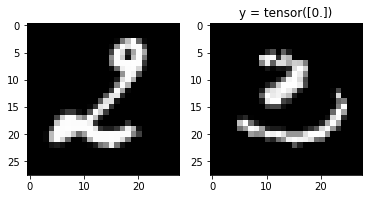

tensor(2) tensor(3)


In [13]:
## showing what the z in the test loader is- ignore
i = 1
j = 0
for x,y,z in testloader:
    j+=1
    p = x[i,:,:,:]
    show_dataComp(p,y[i,:])
    #print(z)
    print(z[0][i],z[1][i])
    if j >= 1:
        break

## Model

In [14]:
ind = 784
hlayers1 = [128,64,10]
hlayer2 = 32
outd = 1

In [28]:
class Model(nn.Module):
    
    def __init__(self, ind, hlayers1, hlayers2, outd):
        super(Model, self).__init__()
        self.net1lin1 = nn.Linear(ind, hlayers1[0])
        self.net1lin2 = nn.Linear(hlayers1[0], hlayers1[1])
        self.net1lin3 = nn.Linear(hlayers1[1], hlayers1[2])
        
        self.net2lin1 = nn.Linear(ind, hlayers1[0])
        self.net2lin2 = nn.Linear(hlayers1[0], hlayers1[1])
        self.net2lin3 = nn.Linear(hlayers1[1], hlayers1[2])
        
        self.agg1 = nn.Linear(2*hlayers1[2], hlayers2)
        self.agg1 = nn.Linear(hlayers2, outd)
        #self.activations1 = []
        #self.activations2 = []
        #self.activations3 = []
        self.activations = []
        self.pairs = []
        
    def forward(self, x, recActivations = False):
        if recActivations:
            print("not done yet")
        else:
            x1 = x[0].view(-1,784)
            x2 = x[1].view(-1,784)
            
            a1 = torch.relu(self.net1lin1(x1))
            a2 = torch.relu(self.net1lin2(a1))
            a3 = torch.relu(self.net1lin3(a2))
            
            
            b1 = torch.relu(self.net2lin1(x2))
            b2 = torch.relu(self.net2lin2(b1))
            b3 = torch.relu(self.net2lin3(b2))
            
            
            return a3,b3
        
    def setPair(self, pair):
        self.pairs.append(pair)


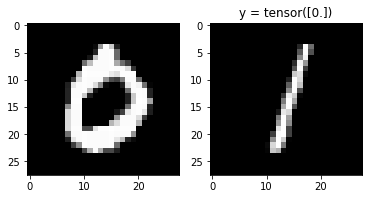

In [27]:
x = testdata[0][0]
show_dataComp(x, testdata[0][1])

In [29]:
model = Model(ind,hlayers1,hlayer2,outd)

In [33]:
a,b = model(x)


torch.Size([1, 10])